In [1]:
from src.fistanet.M5FISTANet import FISTANet
from src.fistanet.M5FISTANetNoST import FISTANetNoST
from src.fistanet.loader import DataSplit
from src.fistanet.solver import Solver
from os.path import join as pjoin
from torchsummary import summary
from datetime import datetime
import numpy as np
import torch

In [2]:
DATA_DIR = './data'
DATA_FILE_GEN = 'generated/BW_master_10000_2024-04-07-12-43-32.pkl'
DATA_FILE_SIGS = 'steinbrinker/testing_data_mvg_avg.npy'
DATA_FILE_BW = 'mit-bih/bw'
DATA_FILE_GAUSS = 'generated/gaussian_noise.npy'
# DATA_FILE_BPDN = 'generated/BW_alphas-BPDN_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN = 'generated/BW_alphas-BPDN-1iters_10000_2024-04-07-12-43-32.npy'
# DATA_FILE_BPDN = 'generated/BW_alphas-BPDN-3iters_10000_2024-04-07-12-43-32.npy'
# DATA_FILE_BPDN = 'generated/BW_alphas-BPDN-5iters_10000_2024-04-07-12-43-32.npy'
DATA_FILE_BPDN_FINAL = 'generated/BW_alphas-BPDN_10000_2024-04-07-12-43-32.npy'
DICT_FILE_BW = 'steinbrinker/dictionary_BW_real_data.npy'
NOISE_TYPE = 'bw'
if NOISE_TYPE == 'bw':
    DATA_FILE_NOISE = DATA_FILE_BW
elif NOISE_TYPE == 'gauss':
    DATA_FILE_NOISE = DATA_FILE_GAUSS
DATA_SIZE = 10000
BATCH_SIZE = 1000
TVT_SPLIT = {
    'train': 80,
    'valid': 10,
    'test': 10
}

FNET_LAYER_NO = 4
FNET_FEATURE_NO = 16
LAMBDA_SP_LOSS = 1e-2
LAMBDA_PRED_SP_LOSS = 1e-3
LAMBDA_SYM_LOSS = 1e-3

EPOCH_NO = 15000
TEST_EPOCH = 15000
LR_DEC_AFTER = 15000
LR_DEC_EVERY = 10
START_EPOCH = 0
START_RUN = '2024-05-28-22-47-56_high-discrepancy_all-zeros-init'
LOG_INTERVAL = 4
LEARNING_RATE = 1e-3



# DATA_FILE_GEN = 'generated/BW_master_7999-8000_2024-04-07-12-43-32.pkl'
# DATA_SIZE = 2
# BATCH_SIZE = 1
# TVT_SPLIT = {
#     'train': 50,
#     'valid': 50,
#     'test': 0
# }
# FNET_LAYER_NO = 4
# FNET_FEATURE_NO = 16
# LEARNING_RATE = 1e-3
# LAMBDA_SP_LOSS = 0.5

In [3]:
trn_ldr, val_ldr, tst_ldr = DataSplit(DATA_DIR, NOISE_TYPE, DATA_FILE_GEN, DATA_FILE_SIGS, DATA_FILE_NOISE, DATA_FILE_BPDN, DATA_FILE_BPDN_FINAL, TVT_SPLIT, BATCH_SIZE)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Psi = np.load(pjoin(DATA_DIR, DICT_FILE_BW))
Psi = torch.from_numpy(Psi)
Psi = Psi.clone().detach().to(device=device)

In [6]:
fista_net = FISTANet(FNET_LAYER_NO, FNET_FEATURE_NO)
fista_net = fista_net.to(device)# define arguments of fista_net

In [7]:
# fista_net = FISTANetNoST(FNET_LAYER_NO, FNET_FEATURE_NO)
# fista_net = fista_net.to(device)# define arguments of fista_net


In [8]:
# summary(fista_net, input_size=(1, 64, 298), device=str(device))
print('Total number of parameters fista net:',
          sum(p.numel() for p in fista_net.parameters()))

Total number of parameters fista net: 18871


In [9]:
dt = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
if START_EPOCH:
    dt = START_RUN
args = {
    'model_name': 'FISTANet',
    'num_epochs': EPOCH_NO,
    'lr': LEARNING_RATE,
    'data_dir': DATA_DIR,
    'save_path': f'D:/USERS/galiger.gergo/ecg-denoising/runs/{dt}',
    'start_epoch': START_EPOCH,
    'start_run': START_RUN,
    'multi_gpu': False,
    'device': device,
    'log_interval': LOG_INTERVAL,
    'test_epoch': TEST_EPOCH,
    'lr_dec_after': LR_DEC_AFTER,
    'lr_dec_every': LR_DEC_EVERY,
    'lambda_sp_loss': LAMBDA_SP_LOSS,
    'lambda_pred_sp_loss': LAMBDA_PRED_SP_LOSS,
    'lambda_sym_loss': LAMBDA_SYM_LOSS
}

In [10]:
solver = Solver(fista_net, Psi, trn_ldr, val_ldr, tst_ldr, BATCH_SIZE, args)

Training epoch 1...

Train Epoch: 1 [0/8000 (0%)]	Batch Loss: 183311007.319347	Learning Rate (w_theta): 0.001000	 TIME:2.5s
				Disc: 183305486.510309		Pred Spars: 8.449677		Sym: 5511.778809		Spars: 0.580552
	 TVw: -0.499000 | TVb: -1.999000 | GSw: -0.201000 | GSb: 0.099000 | TSUw: 0.499000 | TSUb: 0.001000

Train Epoch: 1 [4000/8000 (50%)]	Batch Loss: 180927844.842223	Learning Rate (w_theta): 0.001000	 TIME:4.1s
				Disc: 180922388.615133		Pred Spars: 8.267296		Sym: 5447.268066		Spars: 0.691729
	 TVw: -0.502178 | TVb: -2.002234 | GSw: -0.204998 | GSb: 0.095002 | TSUw: 0.495002 | TSUb: 0.004997
Validating epoch 1...
-------------------------------------------
Epoch statistics:
Average training loss: 190685578.73871902
Average validation loss: 182120583.36843544
Training epoch 2...

Train Epoch: 2 [0/8000 (0%)]	Batch Loss: 164967388.926174	Learning Rate (w_theta): 0.001000	 TIME:6.2s
				Disc: 164962288.378426		Pred Spars: 7.893655		Sym: 5091.630859		Spars: 1.023234
	 TVw: -0.505978 | T

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\galiger.gergo\AppData\Local\Temp\ipykernel_23072\3719546261.py", line 1, in <module>
    solver.train()
  File "C:\Users\galiger.gergo\Desktop\ecg-denoising\workspace\src\fistanet\solver.py", line 353, in train
    train_losses['sum'].append(loss.item())
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\ultrat

TypeError: object of type 'NoneType' has no len()

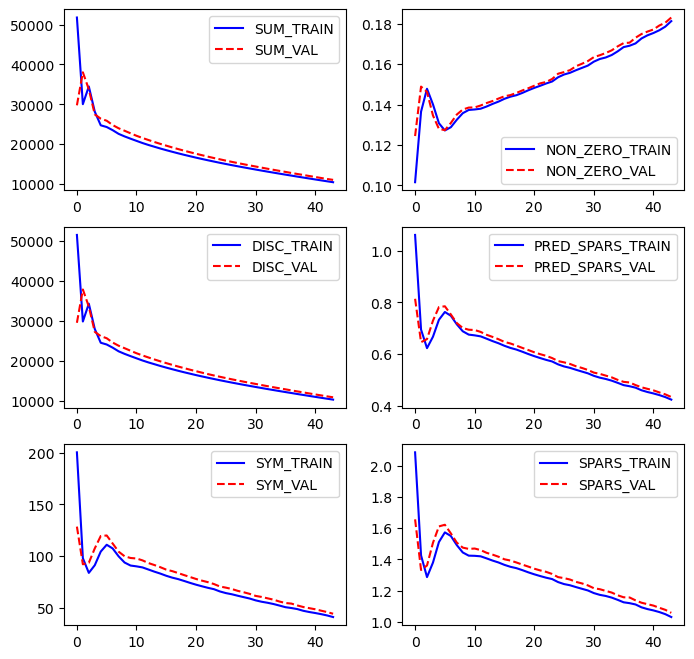

In [11]:
solver.train()

In [ ]:
preds, runtime = solver.test()

In [ ]:
preds.shape

In [ ]:
runtime